<a href="https://colab.research.google.com/github/ricardoemf03/applied-physics/blob/main/condensed-matter-physics/colloidal_particles_in_a_Lennard_Jones_Potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Study of the Dynamics of Colloidal Particles in a Lennard-Jones Potential through Verlet Integration Simulations**
#### **Ricardo José Manuel Escobar Matzir**
#### **condensed matter physics**

##Define the problem and the functions to use


In [ ]:
#We define the useful functions
import numpy as np

# Lennard-Jones potential function
def potencialLJ(r, eps, sigma):
    if r == 0:
        return 0  # We avoid division by zero
    return 4 * eps * ((sigma / r)**12 - (sigma / r)**6)

#Less the derivative of the LJ potential: radial force
def fuerzaLJ(r, eps, sigma, radio):
    r_min = 2 * radio  # Minimum distance allowed between particles
    if r < r_min:
        return 0  #  We avoid division by zero
    return 24 * eps * (2 * (sigma / r)**12 - (sigma / r)**6) / r

#we define the Verlet algorithm that returns the next position
#from the current position (x) and the previous one (x_anterior).
def verlet(x, x_anterior, fuerza, dt, masas):
    return 2 * x - x_anterior + (fuerza/masas) * dt**2

def rebote(x, v, box_size, radio):
    if x < radio:  # Bounce off the left/bottom wall
        x = 2 * radio - x
        v = -v
    elif x > box_size - radio:  # Bounce off the right/upper wall
        x = 2 * (box_size - radio) - x
        v = -v
    return x, v



We define the function that calculates the trajectories of the 4 particles.

In [ ]:
import numpy as np

def calcular_trayectorias(L, dt, pasos, eps, sigma, masas, posiciones, velocidades):
    radio = L / 20    #radius of the particles, modeling as disks
    d = 0.5
    k = 1 #
    box_size = L+k +2*radio #display box size



    x_anterior = posiciones - velocidades * dt  # Previous positions
    fuerzas = np.zeros_like(posiciones)  # Initial forces
    trayectoria = [posiciones.copy()]  # Storing trajectories

    # Calculate the initial forces
    for i in range(len(posiciones)):
        for j in range(len(posiciones)):
            if i != j:
                r_vector = posiciones[i] - posiciones[j]
                r = np.linalg.norm(r_vector)
                if r > 2 * radio:  # Only calculate forces if they are outside the collision radius
                  fuerzas[i] += fuerzaLJ(r, eps, sigma, radio) * (r_vector / r)

    # Simulation
    for t in range(pasos):
        nuevas_posiciones = np.zeros_like(posiciones)
        nuevas_fuerzas = np.zeros_like(fuerzas)

        # Updating positions using Verlet
        for i in range(len(posiciones)):
            nuevas_posiciones[i] = verlet(posiciones[i], x_anterior[i], fuerzas[i], dt, masas)
            #nuevas_posiciones[i] = periodica(nuevas_posiciones[i], box_size)  # Aplicar condiciones periódicas
            # Apply bounce to walls
            nuevas_posiciones[i][0], velocidades[i][0] = rebote(nuevas_posiciones[i][0], velocidades[i][0], box_size, radio)  # Eje X
            nuevas_posiciones[i][1], velocidades[i][1] = rebote(nuevas_posiciones[i][1], velocidades[i][1], box_size, radio)  # Eje Y


        # Calculate the forces for the new positions
        for i in range(len(nuevas_posiciones)):
            for j in range(len(nuevas_posiciones)):
                if i != j:
                    r_vector = nuevas_posiciones[i] - nuevas_posiciones[j]
                    r = np.linalg.norm(r_vector)
                    if r < 2 * radio:  # If they get too close, separate them.
                      ajuste = (2 * radio - r) / 2  # Amount to adjust positions
                      direccion = r_vector / r  # Correction address
                      nuevas_posiciones[i] += ajuste * direccion
                      nuevas_posiciones[j] -= ajuste * direccion
                    if r > 2 * radio:  # Only calculate forces if they are outside the collision radius
                      nuevas_fuerzas[i] += fuerzaLJ(r, eps, sigma, radio) * (r_vector / r)

        # Save path
        trayectoria.append(nuevas_posiciones.copy())

        # Update for next step
        x_anterior = posiciones
        posiciones = nuevas_posiciones
        fuerzas = nuevas_fuerzas

    # Convert path to matrix for animation
    trayectoria = np.array(trayectoria)
    return trayectoria, box_size

##Implementation - Case 1



* Initial positions at the corner of a square with side \\(L\\).
* Zero initial velocities.

In this situation we tested 3 conditions

1. $L=1.1$ with 10,000 steps
2. $L=1.66$ with 1,000 steps
2. $L=1.76$ with 5,000 steps





In [ ]:
#We set the conditions
L=1.1
d= 0.5
dt = 0.001
sigma = 1.5
posiciones = np.array([
        [0+d, 0+d],      # Particle 1
        [L+d, 0+d],      # Particle 2
        [L+d, L+d],      # Particle 3
        [0+d, L+d]       # Particle 4
    ], dtype=float)
velocidades = np.zeros_like(posiciones)  # Initial velocities


trayectoria = calcular_trayectorias(L = L,
                                    dt = dt,
                                    pasos = 10000,
                                    eps =  1,
                                    sigma =  sigma,
                                    masas =  1,
                                    posiciones=posiciones,
                                    velocidades = velocidades)
box_size = trayectoria[1]
trayectoria = trayectoria[0]

We analyze the distances between particles. How does it behave as time passes?

Variaciones de las distancias entre partículas:
 [[0.         0.01293137 0.02586274 0.01293137]
 [0.01293137 0.         0.01293137 0.02586274]
 [0.02586274 0.01293137 0.         0.01293137]
 [0.01293137 0.02586274 0.01293137 0.        ]]


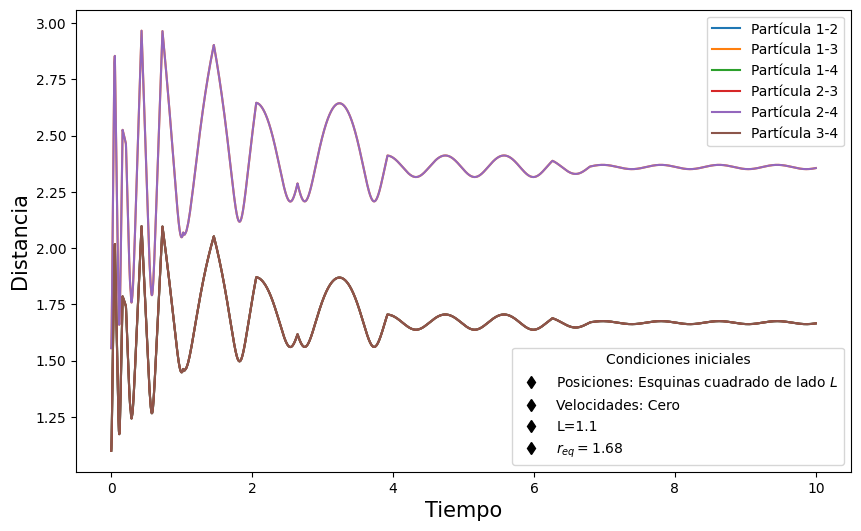

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to calculate distances between all particles
def calcular_distancias(trayectoria):
    num_frames, num_particulas, _ = trayectoria.shape
    distancias = np.zeros((num_frames, num_particulas, num_particulas))

    for t in range(num_frames):
        for i in range(num_particulas):
            for j in range(num_particulas):
                if i != j:
                    distancias[t, i, j] = np.linalg.norm(trayectoria[t, i] - trayectoria[t, j])
    return distancias

# Calculate distances
distancias = calcular_distancias(trayectoria)

# Evaluate whether the distances stabilize (e.g. by taking the variance over time)
variaciones = np.var(distancias, axis=0)
print("Variations in the distances between particles:\n", variaciones)



# Calculate the average distances between particles over time
num_frames, num_particulas, _ = distancias.shape

# Select the distances between the unique pairs
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(num_frames) * dt  # Rescale frames
for i in range(num_particulas):
    for j in range(i + 1, num_particulas):  # Avoid duplicates
        ax.plot(x_values, distancias[:, i, j], label=f'Partícula {i+1}-{j+1}')

additional_legend_elements = [
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Posiciones: Esquinas cuadrado de lado $L$'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Velocidades: Cero'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label=f'L={L}'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='$r_{eq}=$1.68')
]

# Setting up the graph
#ax.set_title("Relative distances between particles over time", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)
ax.set_ylabel("Distance", fontsize = 15)
#ax.legend(loc='best')
current_legend = ax.legend(loc='best')
ax.add_artist(current_legend)
ax.legend(handles=additional_legend_elements, loc='lower right', title="Initial conditions")
plt.savefig("caso1_3.pdf")
plt.show()


Graficamos la posición inicial y final de las partículas.

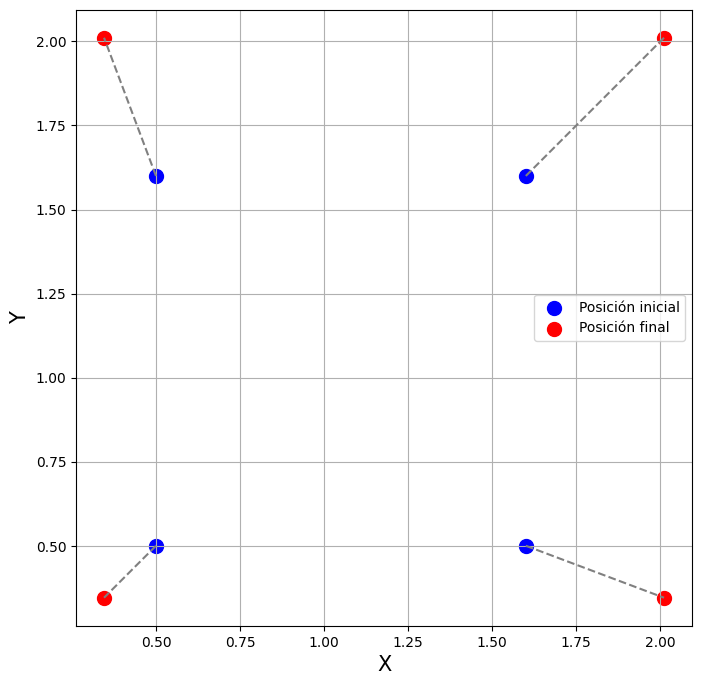

In [ ]:
# Get start and end positions
pos_inicial = trayectoria[0]  # 2D array of initial positions
pos_final = trayectoria[-1]   # 2D array of final positions

# Create the figure
plt.figure(figsize=(8, 8))
#plt.title("Initial and final positions of particles", fontsize = 15)

# Charting initial positions
plt.scatter(pos_inicial[:, 0], pos_inicial[:, 1], color='blue', label="Starting position", s=100)

# Plot final positions
plt.scatter(pos_final[:, 0], pos_final[:, 1], color='red', label="Final position", s=100)

# Drawing lines to visualize displacements
for i in range(len(pos_inicial)):
    plt.plot([pos_inicial[i, 0], pos_final[i, 0]],
             [pos_inicial[i, 1], pos_final[i, 1]],
             color='gray', linestyle='--')

# Setting up the chart
plt.xlabel("X", fontsize = 15)
plt.ylabel("Y", fontsize = 15)
plt.legend()
plt.gca().set_aspect('equal')  # Make the axes proportional
plt.grid(True)
plt.savefig("POScaso1_3.pdf")
plt.show()

## Implementation - Case 2


* Initial positions at the corner of a square with side \\(L\\).
* Random initial velocities. Maxwell-Boltzmann random velocity distribution.



In [ ]:
kb = 1
T = 23
N = 4
masas = 1
L=1.4
d= 0.5
dt = 0.001
std_dev = np.sqrt(kb * T / masas)  # Standard deviation for the distribution
velocidades = np.random.normal(0, std_dev, (N, 2))  # Velocities in x and y for each particle

posiciones = np.array([
        [0+d, 0+d],      # Particle 1
        [L+d, 0+d],      # Particle 2
        [L+d, L+d],      # Particle 3
        [0+d, L+d]       # Particle 4
    ], dtype=float)
trayectoria2 = calcular_trayectorias(L = L,
                                    dt = dt,
                                    pasos = 20000,
                                    eps =  1,
                                    sigma =  1.5,
                                    masas =  masas,
                                    posiciones=posiciones,
                                    velocidades = velocidades)
box_size = trayectoria2[1]
trayectoria2 = trayectoria2[0]

Variaciones de las distancias entre partículas:
 [[0.         0.0050686  0.05584776 0.01036257]
 [0.0050686  0.         0.00621662 0.09052263]
 [0.05584776 0.00621662 0.         0.0080918 ]
 [0.01036257 0.09052263 0.0080918  0.        ]]


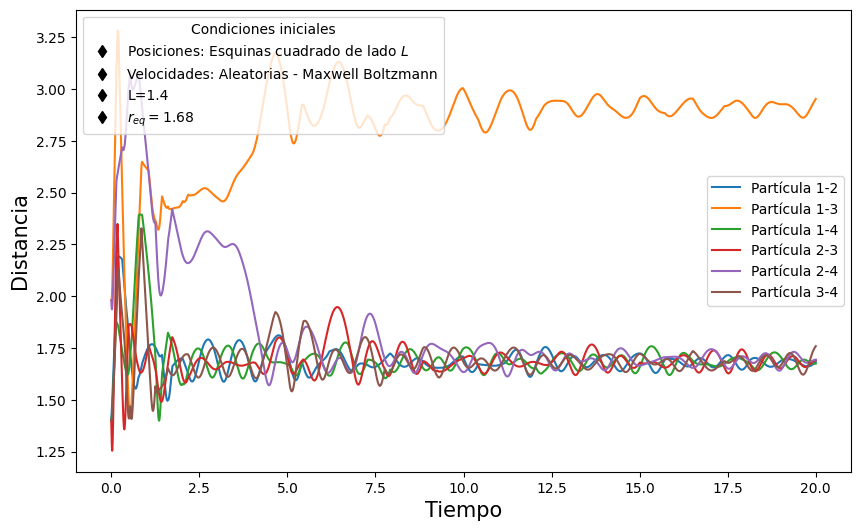

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to calculate distances between all particles
def calcular_distancias(trayectoria):
    num_frames, num_particulas, _ = trayectoria.shape
    distancias = np.zeros((num_frames, num_particulas, num_particulas))

    for t in range(num_frames):
        for i in range(num_particulas):
            for j in range(num_particulas):
                if i != j:
                    distancias[t, i, j] = np.linalg.norm(trayectoria[t, i] - trayectoria[t, j])
    return distancias

# Calculate distances
distancias = calcular_distancias(trayectoria2)

# Evaluate whether the distances stabilize (e.g. by taking the variance over time)
variaciones = np.var(distancias, axis=0)
print("Variations in the distances between particles:\n", variaciones)



# Calculate the average distances between particles over time
num_frames, num_particulas, _ = distancias.shape

# Select the distances between the unique pairs
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(num_frames) * dt  # Rescale frames
for i in range(num_particulas):
    for j in range(i + 1, num_particulas):  # Avoid duplicates
        ax.plot(x_values, distancias[:, i, j], label=f'Particle {i+1}-{j+1}')

additional_legend_elements = [
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Positions: Square corners with side $L$'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Velocities: Random - Maxwell Boltzmann'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label=f'L={L}'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='$r_{eq}=$1.68')
]

# Setting up the graph
#ax.set_title("Relative distances between particles over time", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)
ax.set_ylabel("Distance", fontsize = 15)
#ax.legend(loc='best')
current_legend = ax.legend(loc='best')
ax.add_artist(current_legend)
ax.legend(handles=additional_legend_elements, loc='upper left', title="Initial conditions")
plt.savefig("caso_2.pdf")
plt.show()


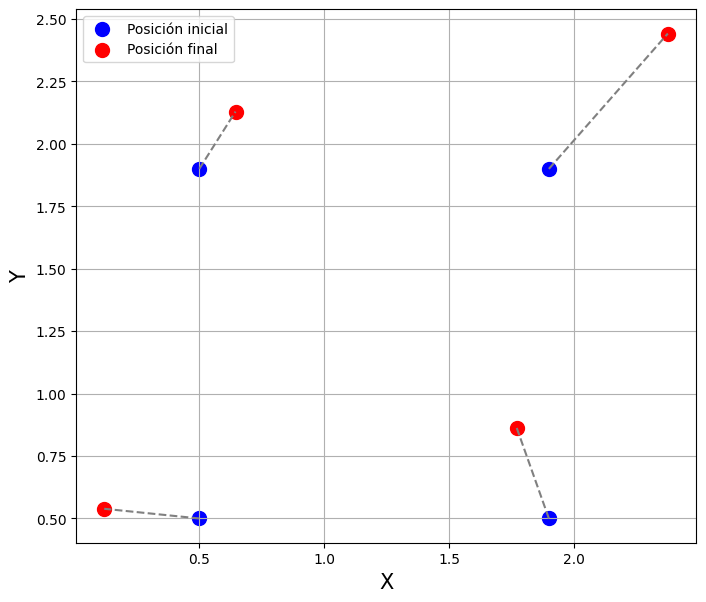

In [ ]:
# Get start and end positions
pos_inicial = trayectoria2[0]  # 2D array of initial positions
pos_final = trayectoria2[-1]   # 2D array of final positions

# Create the figure
plt.figure(figsize=(8, 8))
#plt.title("Initial and final positions of particles", fontsize = 15)

# Charting initial positions
plt.scatter(pos_inicial[:, 0], pos_inicial[:, 1], color='blue', label="Starting position", s=100)

# Plot final positions
plt.scatter(pos_final[:, 0], pos_final[:, 1], color='red', label="Final position", s=100)

# Drawing lines to visualize displacements
for i in range(len(pos_inicial)):
    plt.plot([pos_inicial[i, 0], pos_final[i, 0]],
             [pos_inicial[i, 1], pos_final[i, 1]],
             color='gray', linestyle='--')

# Setting up the chart
plt.xlabel("X", fontsize = 15)
plt.ylabel("Y", fontsize = 15)
plt.legend()
plt.gca().set_aspect('equal')  # Make the axes proportional
plt.grid(True)
plt.savefig("POScaso_2.pdf")
plt.show()

## Implementation - Case 3



* Random initial positions.
* Zero initial velocities.



In [ ]:
L=1.4
d= 0.5
dt = 0.001
#Next we define 3 configurations that will have random initial positions
#configuration 1
posiciones1 = np.array([
        [0+d, 0+d],      # Particle 1
        [L+d+0.1, 0+d],      # Particle 2
        [L+d-0.5, L+d-0.4],      # Particle 3
        [0+d, L+d+0.3]       # Particle 4
    ], dtype=float)
#configuración 2
posiciones2 = np.array([
        [0+d-0.1, 0+d+0.2],      # Particle 1
        [L+d-0.5, 0+d-0.1],      # Particle 2
        [L+d-0.2, L+d-0.7],      # Particle 3
        [0+d, L+d-0.3]       # Particle 4
    ], dtype=float)
#configuración 3
posiciones3 = np.array([
        [0+d+L/5, 0+d+L/5],      # Particle 1
        [L+d-L/10, 0+d+L/4],      # Particle 2
        [L+d-L/15, L+d-L/7],      # Particle 3
        [0+d, L+d]       # Particle 4
    ], dtype=float)
velocidades = np.zeros_like(posiciones1)  # Zero initial velocities
trayectoria3 = calcular_trayectorias(L = L,
                                    dt = dt,
                                    pasos = 20000,
                                    eps =  1,
                                    sigma =  1.5,
                                    masas =  1,
                                    posiciones=posiciones3, #Modify here the positions to be used in the 3 previous cases
                                    velocidades = velocidades)
box_size = trayectoria3[1]
trayectoria3 = trayectoria3[0]

Variaciones de las distancias entre partículas:
 [[0.         0.00625122 0.0604276  0.03175935]
 [0.00625122 0.         0.01771758 0.0127456 ]
 [0.0604276  0.01771758 0.         0.01173161]
 [0.03175935 0.0127456  0.01173161 0.        ]]


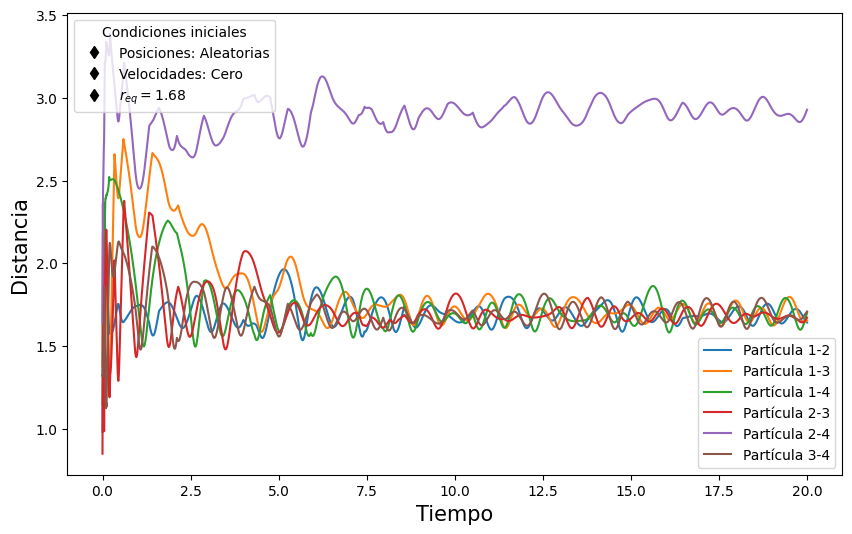

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to calculate distances between all particles
def calcular_distancias(trayectoria):
    num_frames, num_particulas, _ = trayectoria.shape
    distancias = np.zeros((num_frames, num_particulas, num_particulas))

    for t in range(num_frames):
        for i in range(num_particulas):
            for j in range(num_particulas):
                if i != j:
                    distancias[t, i, j] = np.linalg.norm(trayectoria[t, i] - trayectoria[t, j])
    return distancias

# Calculate distances
distancias = calcular_distancias(trayectoria3)

# Evaluate whether the distances stabilize (e.g. by taking the variance over time)
variaciones = np.var(distancias, axis=0)
print("Variations in the distances between particles:\n", variaciones)



# Calculate the average distances between particles over time
num_frames, num_particulas, _ = distancias.shape

# Select the distances between the unique pairs
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(num_frames) * dt  # Rescale frames
for i in range(num_particulas):
    for j in range(i + 1, num_particulas):  # Avoid duplicates
        ax.plot(x_values, distancias[:, i, j], label=f'Particle {i+1}-{j+1}')

additional_legend_elements = [
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Positions: Random'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Speeds: Zero'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='$r_{eq}=$1.68')
]

# Setting up the graph
#ax.set_title("Relative distances between particles over time", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)
ax.set_ylabel("Distance", fontsize = 15)
#ax.legend(loc='best')
current_legend = ax.legend(loc='best')
ax.add_artist(current_legend)
ax.legend(handles=additional_legend_elements, loc='upper left', title="Initial conditions")
plt.savefig("caso_3.pdf")
plt.show()

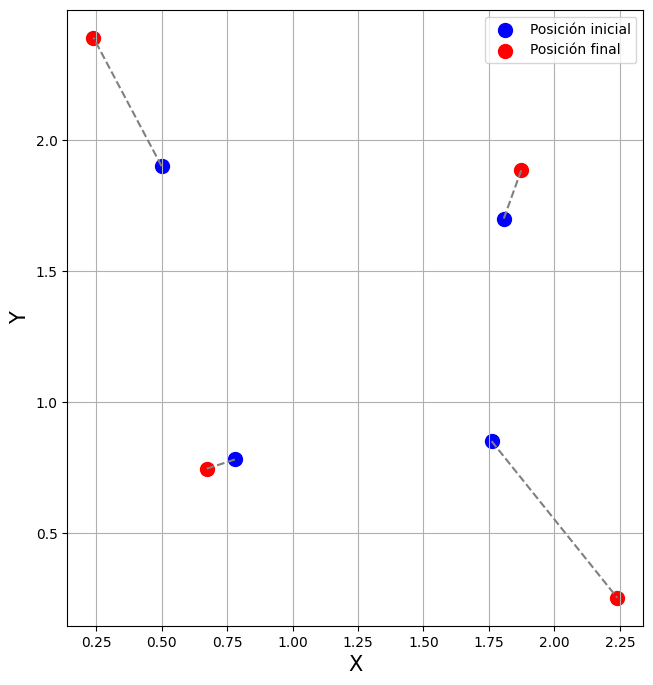

In [ ]:
# Get start and end positions
pos_inicial = trayectoria3[0]  # 2D array of initial positions
pos_final = trayectoria3[-1]   #2D array of final positions

# Create the figure
plt.figure(figsize=(8, 8))
#plt.title("Initial and final positions of particles", fontsize = 15)

# Charting initial positions
plt.scatter(pos_inicial[:, 0], pos_inicial[:, 1], color='blue', label="Starting position", s=100)

# Graficar posiciones finales
plt.scatter(pos_final[:, 0], pos_final[:, 1], color='red', label="Final position", s=100)

# Drawing lines to visualize displacements
for i in range(len(pos_inicial)):
    plt.plot([pos_inicial[i, 0], pos_final[i, 0]],
             [pos_inicial[i, 1], pos_final[i, 1]],
             color='gray', linestyle='--')

# Setting up the chart
plt.xlabel("X", fontsize = 15)
plt.ylabel("Y", fontsize = 15)
plt.legend()
plt.gca().set_aspect('equal')  # Make the axes proportional
plt.grid(True)
plt.savefig("POScaso_3.pdf")
plt.show()

## Implementation - Case 4



* Random initial positions
* Random initial velocities



In [ ]:
L=1.4
d= 0.5
dt = 0.001
kb = 1
T = 210
N = 4
masas = 1
std_dev = np.sqrt(kb * T / masas)  # Standard deviation for the distribution
velocidades = np.random.normal(0, std_dev, (N, 2))  # Velocities in x and y for each particle
#Next we define 3 configurations that will have random initial positions
#configuration 1
posiciones1 = np.array([
        [0+d, 0+d],      # Particle 1
        [L+d+0.1, 0+d],      # Particle 2
        [L+d-0.5, L+d-0.4],      # Particle 3
        [0+d, L+d+0.3]       # Particle 4
    ], dtype=float)
#configuración 2
posiciones2 = np.array([
        [0+d-0.1, 0+d+0.2],      # Particle 1
        [L+d-0.5, 0+d-0.1],      # Particle 2
        [L+d-0.2, L+d-0.7],      # Particle 3
        [0+d, L+d-0.3]       # Particle 4
    ], dtype=float)
#configuración 3
posiciones3 = np.array([
        [0+d+L/5+0.25, 0+d+L/5+0.5],      # Particle 1
        [L+d-L/10, 0+d+L/4],      # Particle 2
        [L+d-L/15, L+d-L/7],      # Particle 3
        [0+d, L+d]       # Particle 4
    ], dtype=float)
trayectoria4 = calcular_trayectorias(L = L,
                                    dt = dt,
                                    pasos = 12000,
                                    eps =  1,
                                    sigma =  1.5,
                                    masas =  1,
                                    posiciones=posiciones3, #Modify here the positions to be used in the 3 previous cases
                                    velocidades = velocidades)
box_size = trayectoria4[1]
trayectoria4 = trayectoria4[0]

Variaciones de las distancias entre partículas:
 [[0.         0.02046199 0.24498772 0.02614441]
 [0.02046199 0.         0.04358999 0.09196291]
 [0.24498772 0.04358999 0.         0.0225383 ]
 [0.02614441 0.09196291 0.0225383  0.        ]]


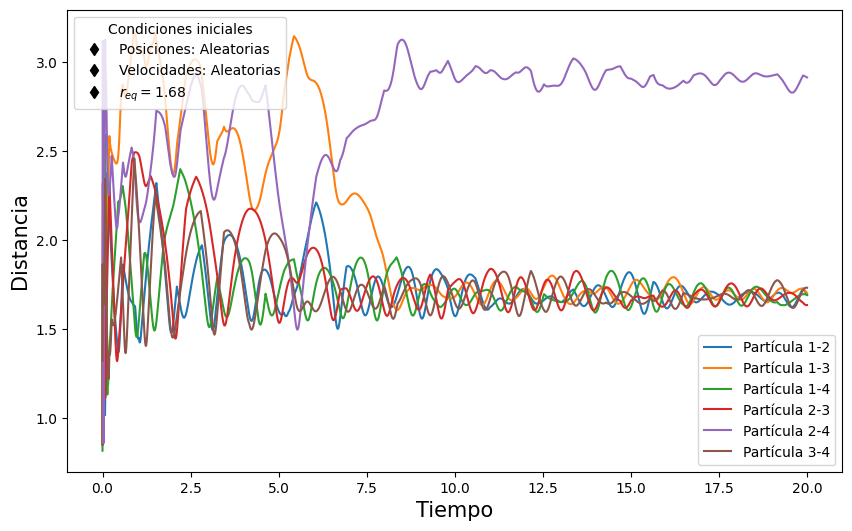

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to calculate distances between all particles
def calcular_distancias(trayectoria):
    num_frames, num_particulas, _ = trayectoria.shape
    distancias = np.zeros((num_frames, num_particulas, num_particulas))

    for t in range(num_frames):
        for i in range(num_particulas):
            for j in range(num_particulas):
                if i != j:
                    distancias[t, i, j] = np.linalg.norm(trayectoria[t, i] - trayectoria[t, j])
    return distancias

# Calculate distances
distancias = calcular_distancias(trayectoria4)

# Evaluate whether the distances stabilize (e.g. by taking the variance over time)
variaciones = np.var(distancias, axis=0)
print("Variations in the distances between particles:\n", variaciones)



# Calculate the average distances between particles over time
num_frames, num_particulas, _ = distancias.shape

# Select the distances between the unique pairs
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(num_frames) * dt  # Rescale frames
for i in range(num_particulas):
    for j in range(i + 1, num_particulas):  # Avoid duplicates
        ax.plot(x_values, distancias[:, i, j], label=f'Particle {i+1}-{j+1}')

additional_legend_elements = [
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Positions: Random'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='Speeds: Random'),
    Line2D([0], [0], c = "black", marker = "d", linestyle='None', label='$r_{eq}=$1.68')
]

# Setting up the graph
#ax.set_title("Relative distances between particles over time", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)
ax.set_ylabel("Distance", fontsize = 15)
#ax.legend(loc='best')
current_legend = ax.legend(loc='best')
ax.add_artist(current_legend)
ax.legend(handles=additional_legend_elements, loc='upper left', title="Initial conditions")
plt.savefig("caso_4.pdf")
plt.show()

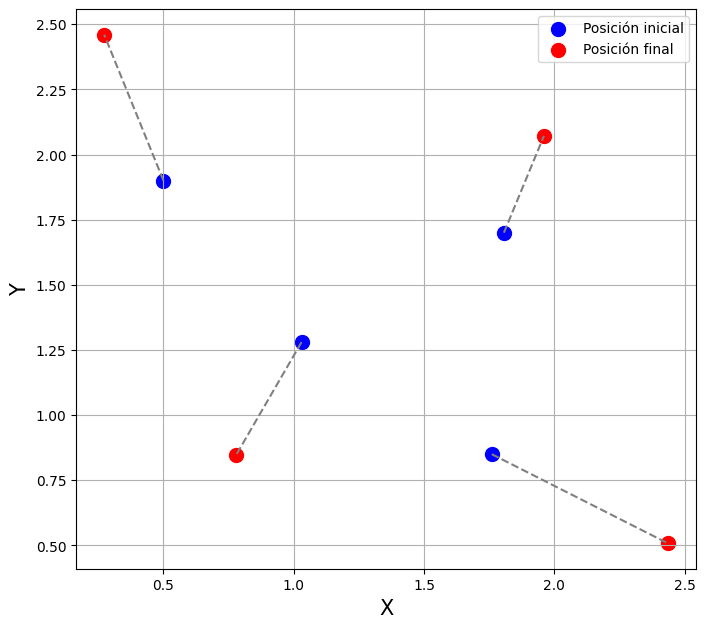

In [ ]:
# Get start and end positions
pos_inicial = trayectoria4[0]  # 2D array of initial positions
pos_final = trayectoria4[-1]   # 2D array of final positions

# Create the figure
plt.figure(figsize=(8, 8))
#plt.title("Initial and final positions of particles", fontsize = 15)

# Charting initial positions
plt.scatter(pos_inicial[:, 0], pos_inicial[:, 1], color='blue', label="Starting position", s=100)

# Plot final positions
plt.scatter(pos_final[:, 0], pos_final[:, 1], color='red', label="Final position", s=100)

# Drawing lines to visualize displacements
for i in range(len(pos_inicial)):
    plt.plot([pos_inicial[i, 0], pos_final[i, 0]],
             [pos_inicial[i, 1], pos_final[i, 1]],
             color='gray', linestyle='--')

# Setting up the chart
plt.xlabel("X", fontsize = 15)
plt.ylabel("Y", fontsize = 15)
plt.legend()
plt.gca().set_aspect('equal')  # Make the axes proportional
plt.grid(True)
plt.savefig("POScaso_4.pdf")
plt.show()

## Illustration of the initial configuration of the particles

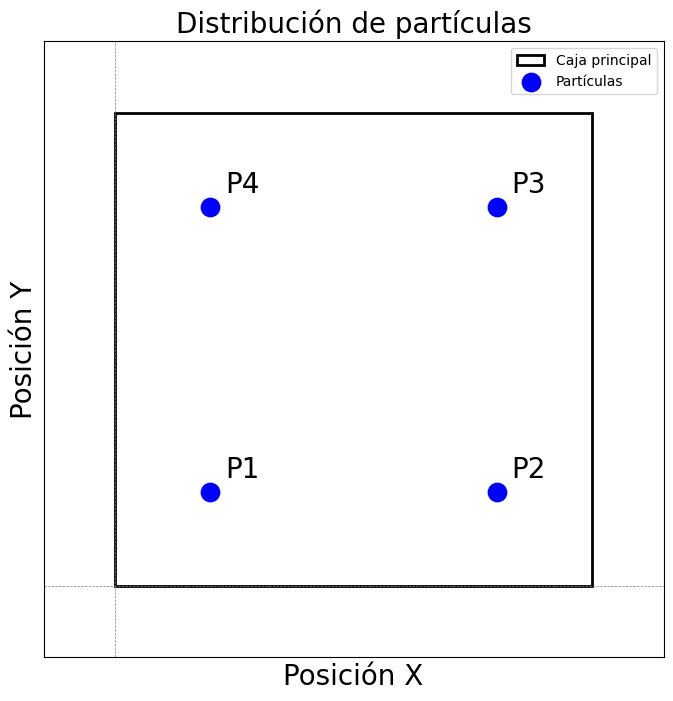

In [ ]:
import matplotlib.pyplot as plt

# System parameters
box_size = 10

# Positions inside the main box
main_box_positions = [
    (2, 2),
    (8, 2),
    (8, 8),
    (2, 8)
]



# Graph
plt.figure(figsize=(8, 8))
plt.title("Particle distribution", fontsize= 20)

# Draw the main box
plt.gca().add_patch(plt.Rectangle((0, 0), box_size, box_size, fill=False, color='black', linewidth=2, label="Caja principal"))

# Plot particles in the main box
x_main, y_main = zip(*main_box_positions)
plt.scatter(x_main, y_main, c='blue', label='Particle', s=175)

# Adding labels to particles
for i, (x, y) in enumerate(main_box_positions):
    plt.text(x + 0.3, y + 0.3, f"P{i+1}", color="black", fontsize=20)




# Chart Settings
plt.xlim(-1.5, 11.5)
plt.ylim(-1.5, 11.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("Position X", fontsize= 20)
plt.ylabel("Position Y", fontsize= 20)
plt.legend()
plt.grid(True)
# Remove axis numbers
ax = plt.gca()  # Get the current axis
ax.set_xticks([])  # Remove numbers from the x-axis
ax.set_yticks([])  # Remove numbers from the y-axis
plt.savefig("confInicial.pdf")
plt.show()


##To make the animation of the evolution of the particles

Warning: Simulations can take up to 32 minutes to compile!

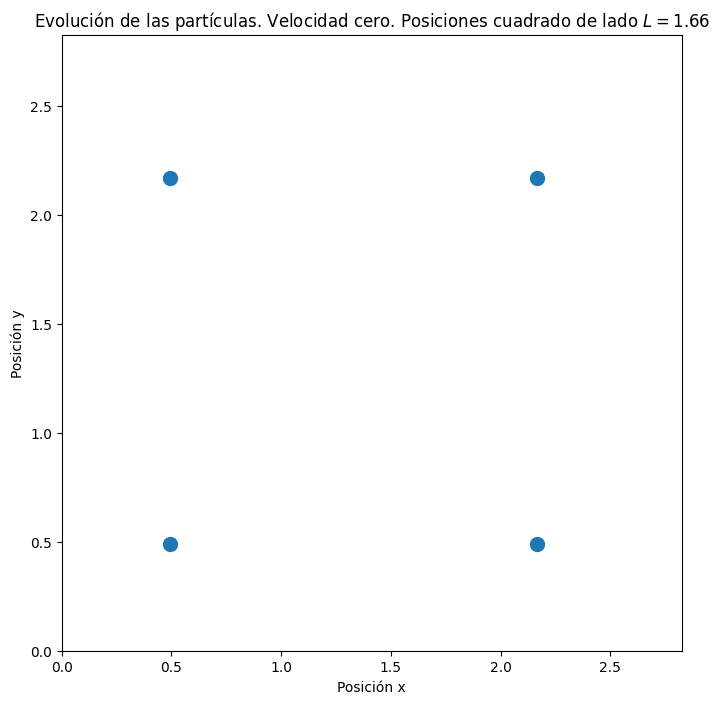

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.animation import FFMpegWriter
graficar_trayectoria = trayectoria #Enter here the path to be graphed, either path2, tranjectory3 or path4
# Create animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
ax.set_title("Evolution of particles. Zero speed. Square positions with side $L=1.66$")
ax.set_xlabel("Position x")
ax.set_ylabel("Position y")
scatter = ax.scatter([], [], s=100, label="Particles")

def update(frame):
    scatter.set_offsets(graficar_trayectoria[frame])
    return scatter,

ani = FuncAnimation(fig, update, frames=len(graficar_trayectoria), interval=50, blit=True)

#Save animation as GIF
video_writer = FFMpegWriter(fps=150, codec="libx264")
ani.save("VIDcaso1_2.mp4", writer=video_writer, dpi=150)
#gif_writer = PillowWriter(fps=30)  # 20 frames per second
#ani.save("GIFcaso1_3.gif", writer=gif_writer)
#print("Animation saved as 'caso1_3.gif'")

